In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [4]:
def load_images(image_folder, mask_folder):
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if os.path.isfile(os.path.join(mask_folder, f)) and f.endswith('.png')])

    if len(image_files) != len(mask_files):
        print(f"Number of images ({len(image_files)}) does not match number of masks ({len(mask_files)}).")
        return None, None

    print(f"Image Files: {image_files}")
    print(f"Mask Files: {mask_files}")

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to read image {img_file}.")
            continue
        
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = np.expand_dims(img, axis=-1) / 255.0  # Normalize and reshape
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Failed to read mask {mask_file}.")
            continue
        
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = np.expand_dims(mask, axis=-1) / 255.0
        
        images.append(img)
        masks.append(mask)

    print(f"Successfully loaded {len(images)} images and {len(masks)} masks.")
    return np.array(images), np.array(masks)

In [6]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 1

In [8]:
train_image_folder = 'train/original_image'
train_mask_folder = 'train/binary_mask'

In [10]:
images, masks = load_images(train_image_folder, train_mask_folder)

Image Files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0

In [26]:
def unet_model(input_size=(128, 128, 1)):
    
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [28]:
def calculate_iou(y_true, y_pred):
    y_true_mask = tf.reshape(tf.math.round(y_true) == 1, [-1, IMG_HEIGHT * IMG_WIDTH])
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred_mask = tf.reshape(y_pred == 1, [-1, IMG_HEIGHT * IMG_WIDTH])

    intersection_mask = tf.math.logical_and(y_true_mask, y_pred_mask)
    union_mask = tf.math.logical_or(y_true_mask, y_pred_mask)

    intersection = tf.reduce_sum(tf.cast(intersection_mask, tf.float32), axis=1)
    union = tf.reduce_sum(tf.cast(union_mask, tf.float32), axis=1)

    iou = tf.where(union == 0, 1., intersection / union)
    return iou

class IntersectionOverUnion(tf.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        iou = calculate_iou(y_true, y_pred)
        return super().update_state(iou, sample_weight)


In [30]:
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [32]:
model = unet_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        IntersectionOverUnion(name='IoU'),
    ])

In [34]:
checkpoint_dir = "checkpoints/run_1/"
os.makedirs(checkpoint_dir, exist_ok=True)


In [36]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/run_1/cp-{epoch:04d}.weights.h5",  
    verbose=1,
    save_weights_only=True  
)

In [38]:
history = model.fit(
    X_train, 
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=32,
    callbacks=[checkpoint_callback] 
)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - IoU: 0.0000e+00 - accuracy: 0.9548 - loss: 1.5262 
Epoch 1: saving model to checkpoints/run_1/cp-0001.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 279s 14s/step - IoU: 0.0000e+00 - accuracy: 0.9558 - loss: 1.4931 - val_IoU: 0.0000e+00 - val_accuracy: 0.9829 - val_loss: 0.1238
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - IoU: 0.0000e+00 - accuracy: 0.9834 - loss: 0.1099 
Epoch 2: saving model to checkpoints/run_1/cp-0002.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 275s 14s/step - IoU: 0.0000e+00 - accuracy: 0.9834 - loss: 0.1094 - val_IoU: 0.0000e+00 - val_accuracy: 0.9829 - val_loss: 0.0893
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - IoU: 0.0000e+00 - accuracy: 0.9832 - loss: 0.0838 
Epoch 3: saving model to checkpoints/run_1/cp-0003.weights.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 273s 14s/step - IoU: 0.0000e+00 - accuracy: 0.9832 - loss: 0.0836 - val_IoU: 0.0000e+00 - val_accuracy: 0.9829 - val_loss: 0.0914
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━

In [41]:
evaluation = model.evaluate(X_val, Y_val)
print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - IoU: 0.0000e+00 - accuracy: 0.9858 - loss: 0.0393
Loss: 0.04058176651597023
Accuracy: 0.9855745434761047


In [54]:
model.save('unet_model_2.h5')

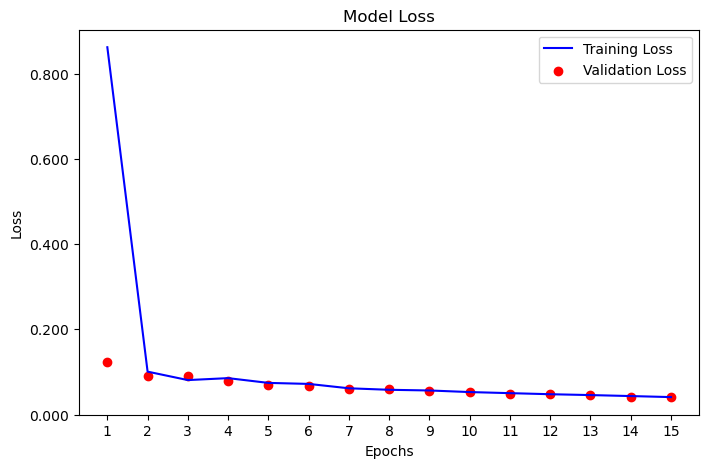

In [89]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(8, 5))

plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
plt.scatter(epochs, history.history['val_loss'], label='Validation Loss', color='red')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

plt.xticks(epochs)  
plt.legend(loc='upper right')

plt.show()


In [73]:
predictions = model.predict(X_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


In [79]:
thresholded_predictions = (predictions > 0.27).astype(np.uint8)

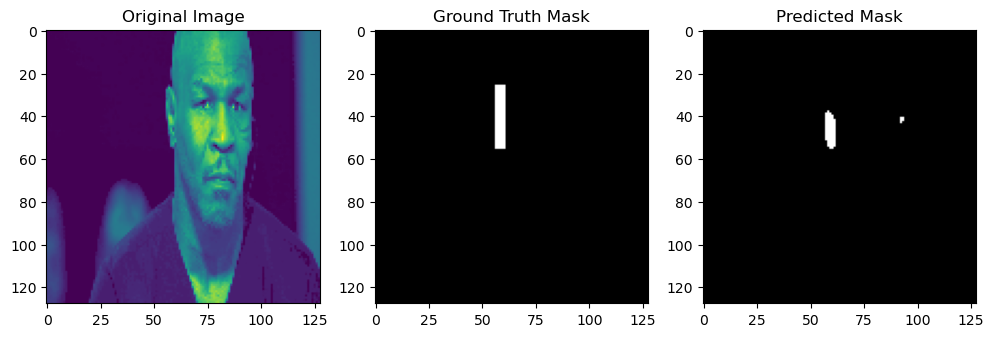

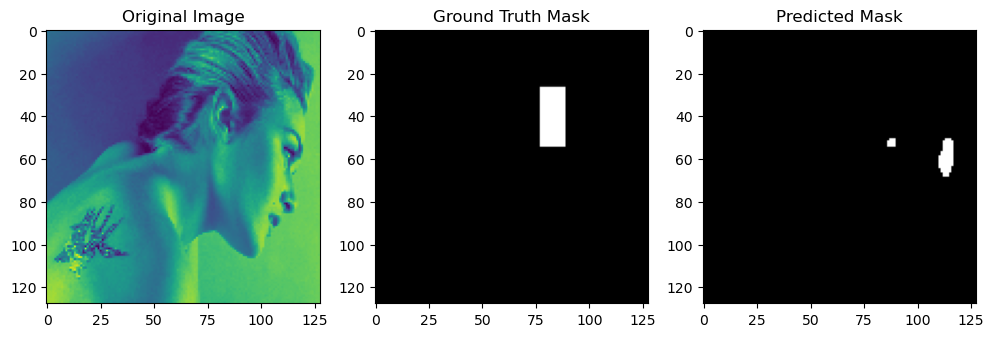

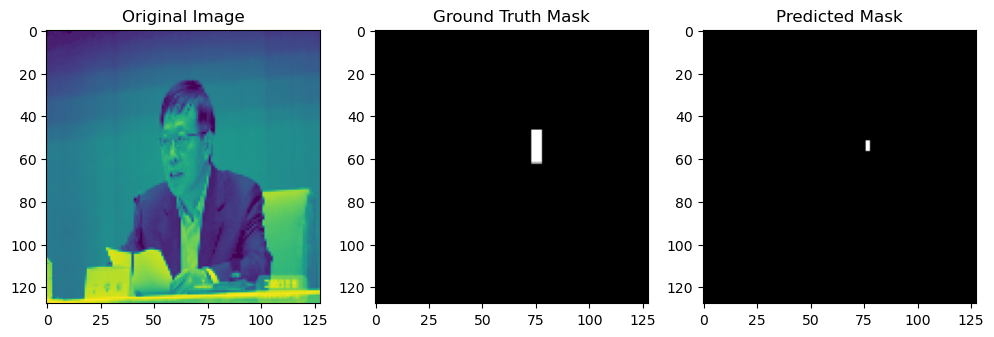

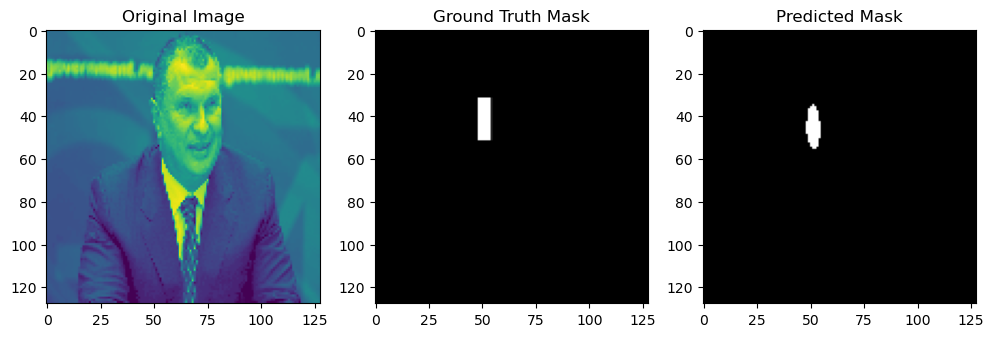

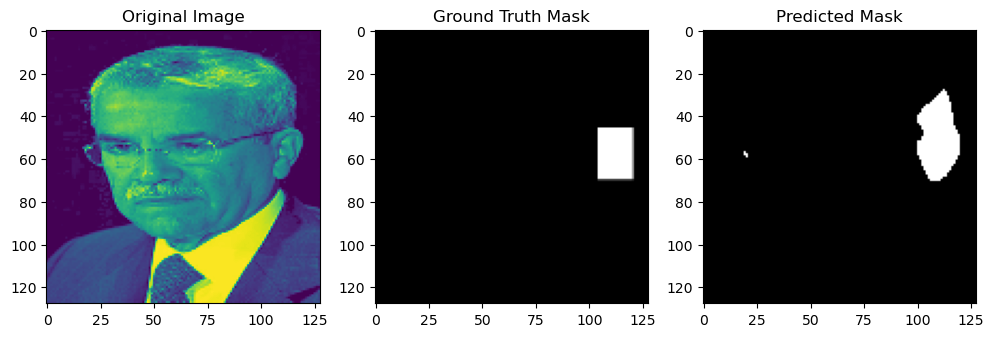

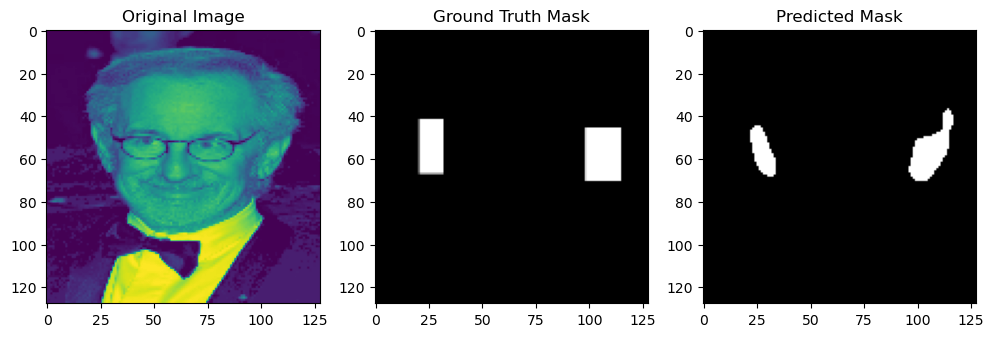

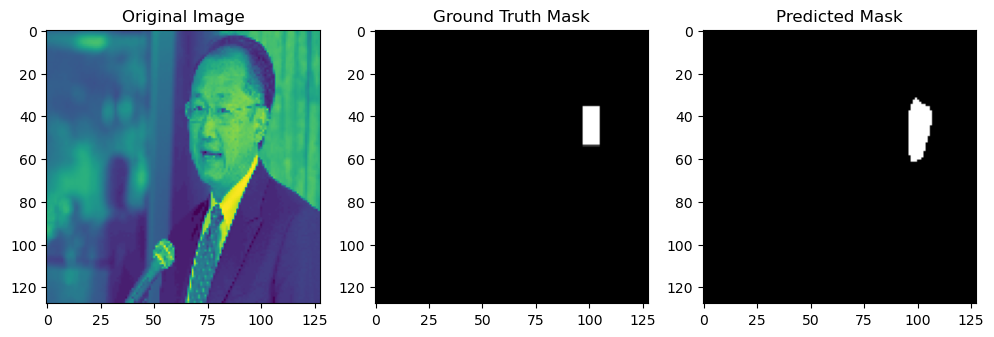

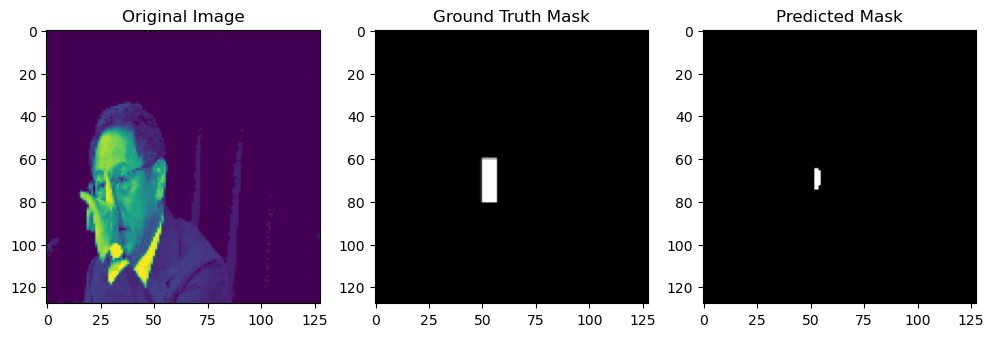

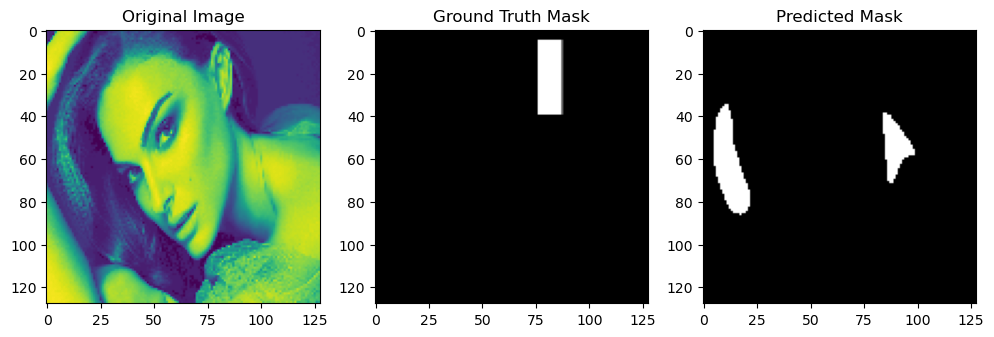

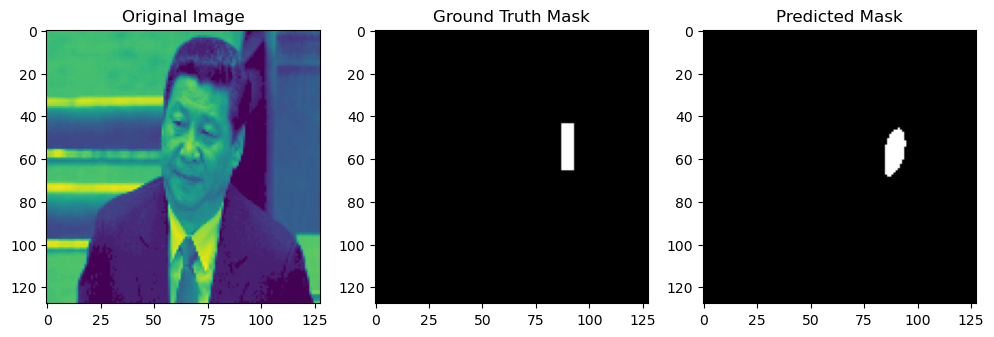

In [81]:
def visualize_prediction(index):
    for i in range(0,index):
        plt.figure(figsize=(12, 8))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i]) 
        plt.title('Original Image')

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(Y_val[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(thresholded_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        plt.show()
    

visualize_prediction(10) 

In [91]:
path_images = 'test/original_images'
path_masks = 'test/binary_images'

In [97]:
X_test,Y_test = load_images(path_images,path_masks)

Image Files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0

In [99]:
predictions = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step


In [101]:
model.evaluate(X_test,Y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - IoU: 0.0000e+00 - accuracy: 0.9863 - loss: 0.0383


[0.03861866518855095, 0.9859650731086731, 0.0]

In [107]:
thresholded_predictions = (predictions > 0.2).astype(np.uint8)

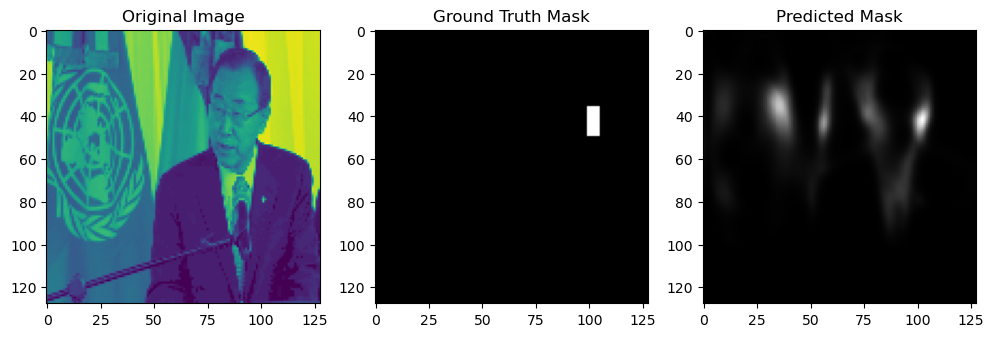

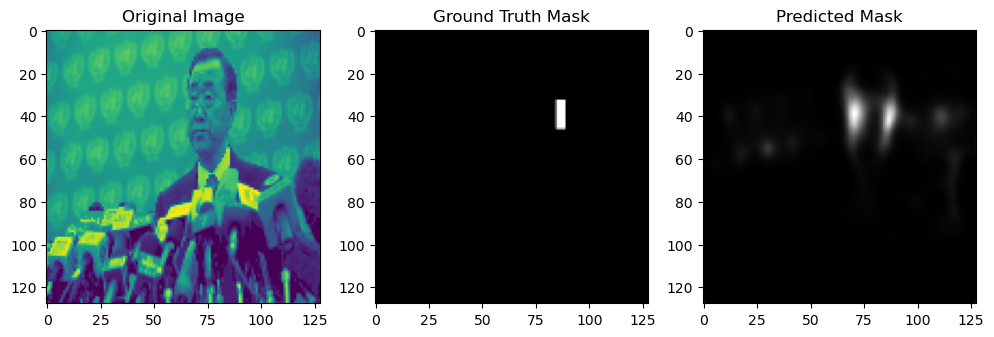

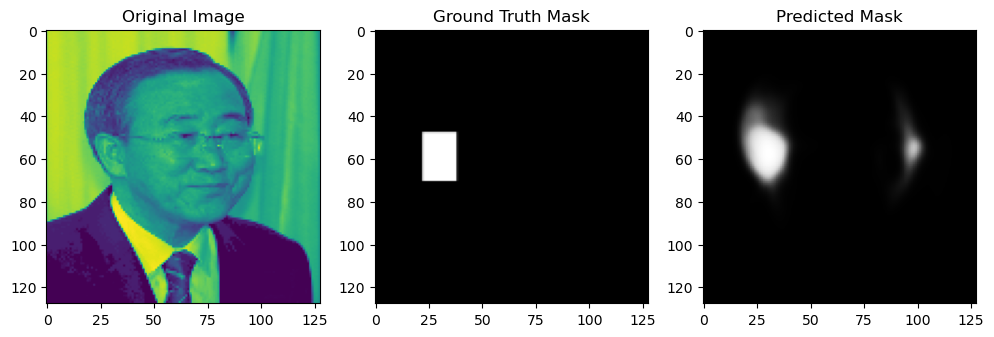

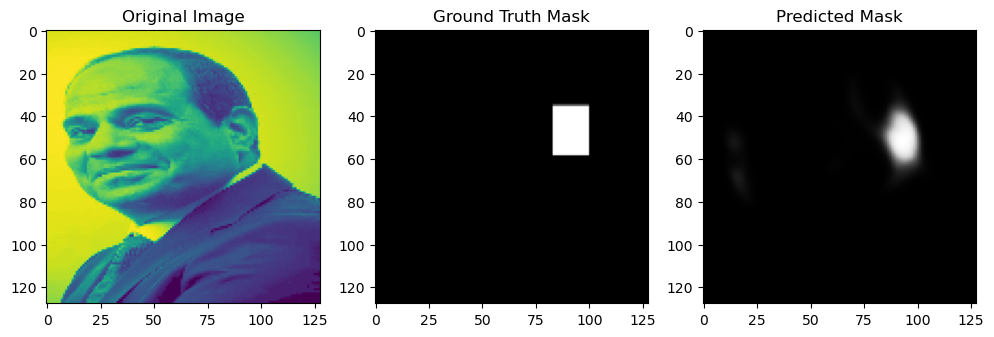

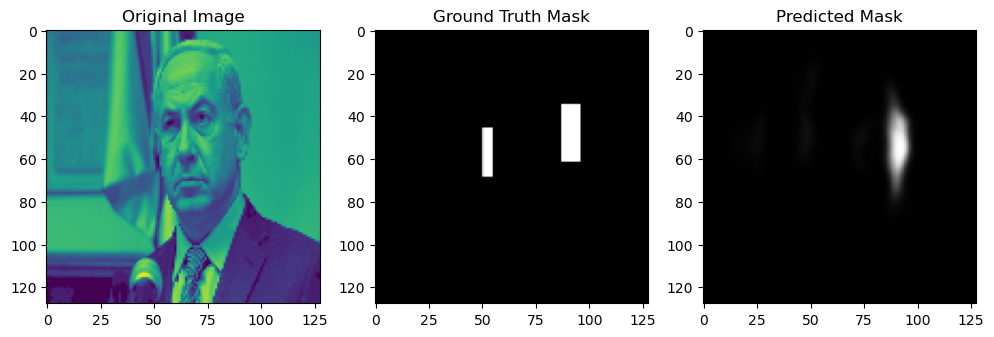

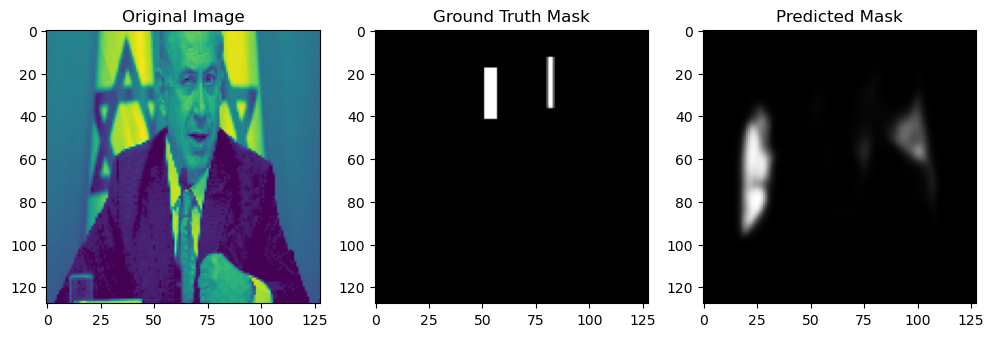

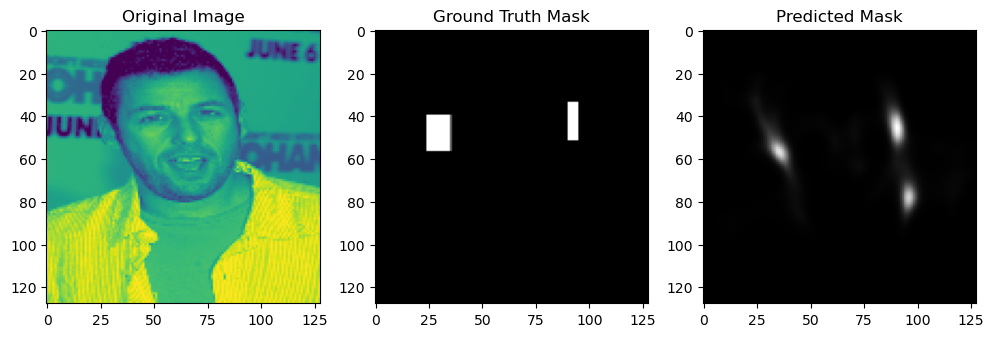

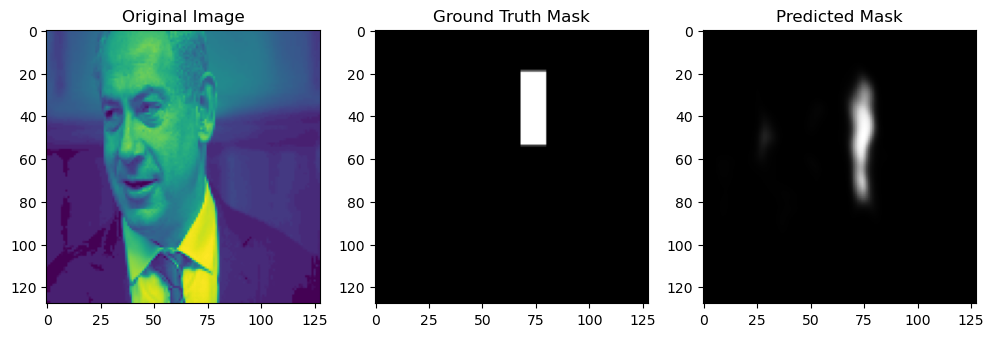

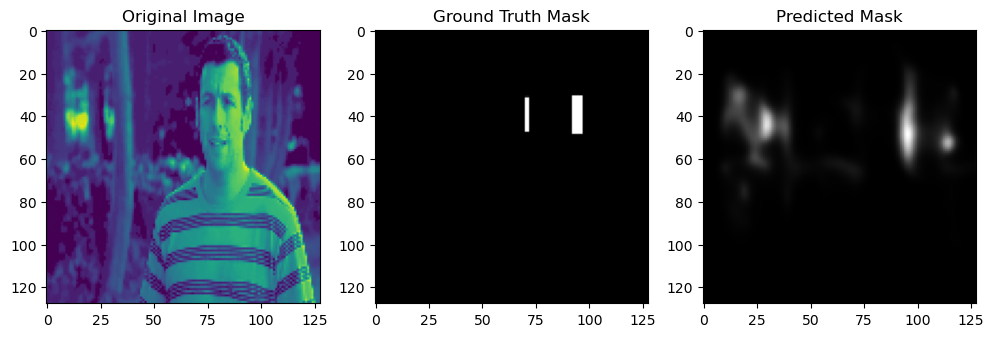

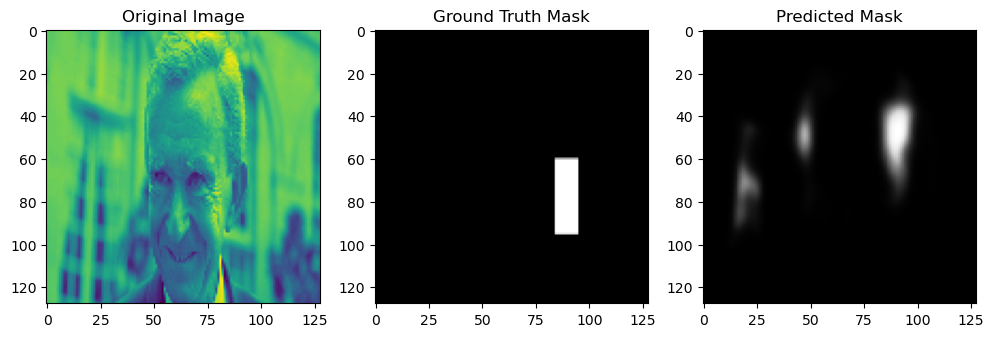

In [115]:
def visualize_prediction(index):
    for i in range(0,index):
        plt.figure(figsize=(12, 8))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i]) 
        plt.title('Original Image')

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(Y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Predicted Mask')

        plt.show()
    

visualize_prediction(10) 